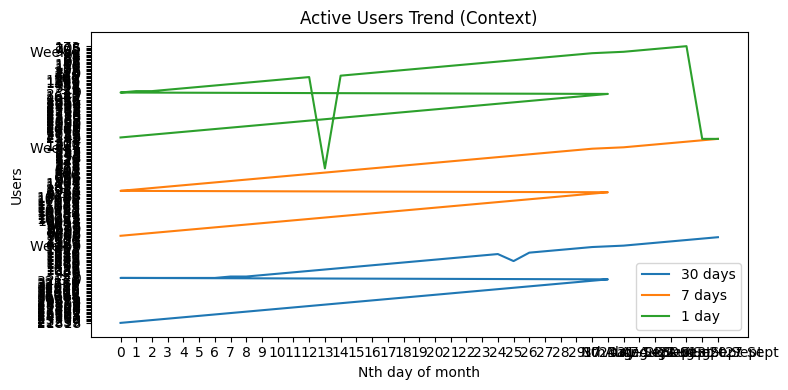

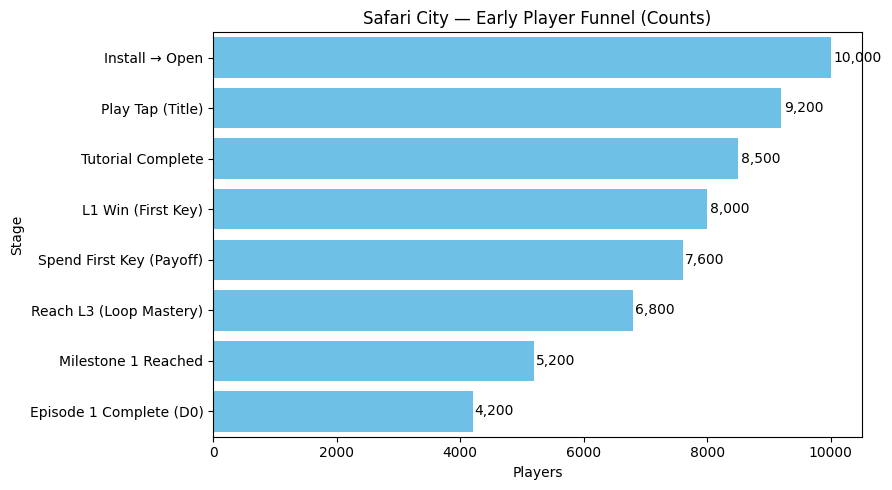

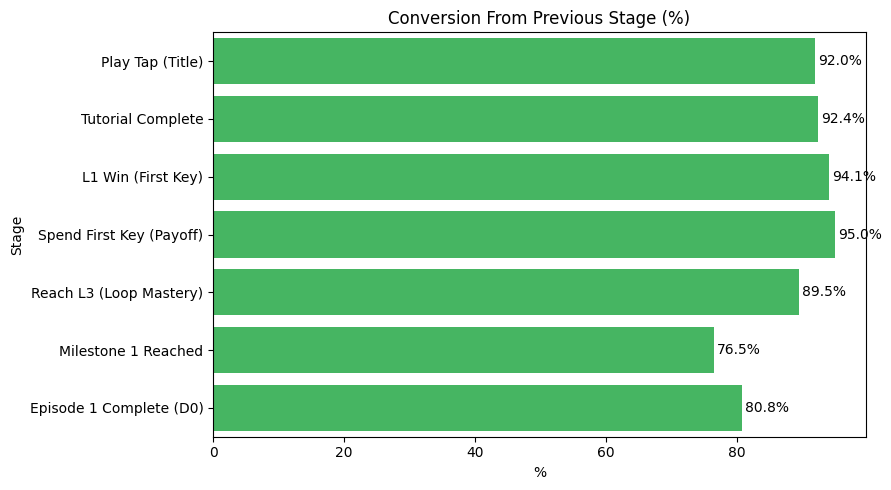


Key Insights:
- Largest drop at 'Milestone 1 Reached': 23.5% from previous stage
- Largest drop at 'Episode 1 Complete (D0)': 19.2% from previous stage
- Largest drop at 'Reach L3 (Loop Mastery)': 10.5% from previous stage
- Tutorial completion: 92.4% (target ≥ 85%)
- Players who earned a key but did not spend immediately: ~400 (consider UI guidance)

Recommendations:
- Bundle small tasks into a bigger reveal; reward with a free booster at milestone.
- Seed a cliffhanger and schedule a tailored D1 notification with next-goal CTA.
- Smooth early difficulty (L2–L3); grant ad-continue on 2nd fail, not paywall.

Tip: Replace funnel_counts with real numbers and re-run to refresh visuals and text.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12504\1155782485.py:110: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



In [3]:
# Safari City — Early Funnel Visualization and Insights
#
# How to use:
# 1) If you only have the provided Firebase overview CSV, this notebook will plot DAU trend.
# 2) For the early funnel, edit the 'funnel_counts' dictionary below with your observed stage counts.
# 3) The notebook will compute conversion rates, visualize the funnel, highlight drop-offs,
#    and print product recommendations.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_colwidth', None)
DATA_DIR = Path(r"c:/Safari City")
CSV_PATH = DATA_DIR / "Firebase_overview - Firebase_overview.csv"

# ---------- Load Firebase overview (for context trend) ----------
try:
    df_overview = pd.read_csv(CSV_PATH, comment='#')
except Exception as e:
    print(f"Could not read overview CSV: {e}")
    df_overview = pd.DataFrame()

# The file has multiple tables separated by headers; keep only rows with the first table's columns
# We expect columns like: 'Nth day','30 days','7 days','1 day'
if not df_overview.empty and 'Nth day' in df_overview.columns:
    dau_cols = [c for c in ['Nth day','30 days','7 days','1 day'] if c in df_overview.columns]
    df_dau = df_overview[dau_cols].dropna(how='any')
else:
    df_dau = pd.DataFrame()

if not df_dau.empty:
    plt.figure(figsize=(8,4))
    for col in [c for c in df_dau.columns if c != 'Nth day']:
        plt.plot(df_dau['Nth day'], df_dau[col], label=col)
    plt.title('Active Users Trend (Context)')
    plt.xlabel('Nth day of month')
    plt.ylabel('Users')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No DAU trend rendered (table not found). Proceeding to funnel.")

# ---------- Early Funnel (EDIT THESE COUNTS as needed) ----------
# Use raw counts for a cohort (e.g., first 24h installs). Replace with your data if available.
# The default numbers are illustrative; they roughly follow targets in Task 1.

funnel_counts = {
    'Install → Open': 10000,
    'Play Tap (Title)': 9200,
    'Tutorial Complete': 8500,
    'L1 Win (First Key)': 8000,
    'Spend First Key (Payoff)': 7600,
    'Reach L3 (Loop Mastery)': 6800,
    'Milestone 1 Reached': 5200,
    'Episode 1 Complete (D0)': 4200,
}

# Compute conversion and drop-offs
stages = list(funnel_counts.keys())
counts = np.array(list(funnel_counts.values()))
conv_from_prev = np.r_[1.0, counts[1:] / counts[:-1]]
conv_from_start = counts / counts[0]

df_funnel = pd.DataFrame({
    'stage': stages,
    'count': counts,
    'conv_from_prev': conv_from_prev,
    'conv_from_start': conv_from_start,
    'drop_from_prev': 1 - conv_from_prev,
})

# Identify largest drop-offs
df_funnel['drop_rank'] = df_funnel['drop_from_prev'].rank(ascending=False, method='first')

# ---------- Visualization ----------
plt.figure(figsize=(9,5))
sns.barplot(data=df_funnel, y='stage', x='count', color='#5ac8fa')
plt.title('Safari City — Early Player Funnel (Counts)')
plt.xlabel('Players')
plt.ylabel('Stage')
for i, (c) in enumerate(df_funnel['count']):
    plt.text(c*1.005, i, f"{c:,}", va='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,5))
sns.barplot(data=df_funnel.iloc[1:], y='stage', x=(df_funnel['conv_from_prev'].iloc[1:]*100), color='#34c759')
plt.title('Conversion From Previous Stage (%)')
plt.xlabel('%')
plt.ylabel('Stage')
for i, p in enumerate(df_funnel['conv_from_prev'].iloc[1:]*100):
    plt.text(p+0.5, i, f"{p:.1f}%", va='center')
plt.tight_layout()
plt.show()

# ---------- Insights ----------
print('\nKey Insights:')
# Top 3 drops excluding the first stage (by definition 0 drop)
insights = df_funnel.iloc[1:].sort_values('drop_from_prev', ascending=False).head(3)
for _, row in insights.iterrows():
    print(f"- Largest drop at '{row['stage']}': {row['drop_from_prev']*100:.1f}% from previous stage")

# Specific checks aligned to your observations
# 1) Tutorial completion
if df_funnel.loc[df_funnel['stage']=='Tutorial Complete','conv_from_prev'].values.size:
    tut_conv = float(df_funnel.loc[df_funnel['stage']=='Tutorial Complete','conv_from_prev'])
    print(f"- Tutorial completion: {tut_conv*100:.1f}% (target ≥ 85%)")
# 2) Key spend latency proxy: assume count difference between key earned and key spent implies friction
if {'L1 Win (First Key)','Spend First Key (Payoff)'} <= set(df_funnel['stage']):
    key_gap = int(df_funnel.loc[df_funnel['stage']=='L1 Win (First Key)','count'].values[0] -
                  df_funnel.loc[df_funnel['stage']=='Spend First Key (Payoff)','count'].values[0])
    print(f"- Players who earned a key but did not spend immediately: ~{key_gap:,} (consider UI guidance)")

# ---------- Recommendations (auto-generated from drops) ----------
print('\nRecommendations:')
for _, row in insights.iterrows():
    stage = row['stage']
    if 'Tutorial' in stage:
        print("- Shorten tutorial steps and add contextual gestures; defer non-critical prompts.")
    elif 'Spend First Key' in stage:
        print("- After first win, auto-pan to the task and pulse the key slot; add instant key feedback.")
    elif 'Milestone' in stage:
        print("- Bundle small tasks into a bigger reveal; reward with a free booster at milestone.")
    elif 'Episode 1' in stage:
        print("- Seed a cliffhanger and schedule a tailored D1 notification with next-goal CTA.")
    elif 'Reach L3' in stage:
        print("- Smooth early difficulty (L2–L3); grant ad-continue on 2nd fail, not paywall.")
    else:
        print("- Add contextual tips and reduce friction around this step.")

print('\nTip: Replace funnel_counts with real numbers and re-run to refresh visuals and text.')


In [4]:
# Plotly visualizations with rounded, abbreviated labels
import plotly.express as px
import plotly.io as pio


def format_count_short(n: float) -> str:
	abs_n = abs(n)
	if abs_n >= 1_000_000_000:
		return f"{n/1_000_000_000:.1f}B"
	if abs_n >= 1_000_000:
		return f"{n/1_000_000:.1f}M"
	if abs_n >= 1_000:
		return f"{n/1_000:.1f}K"
	return f"{n:.0f}"

# Counts bar (horizontal)
fig_counts = px.bar(
	df_funnel,
	x='count', y='stage', orientation='h',
	title='Safari City — Early Player Funnel (Counts)',
	color_discrete_sequence=['#5ac8fa']
)
fig_counts.update_traces(
	text=df_funnel['count'].apply(format_count_short),
	textposition='outside',
	cliponaxis=False
)
fig_counts.update_layout(
	xaxis_title='Players', yaxis_title='Stage',
	xaxis=dict(tickformat='~s'),
	margin=dict(l=140, r=20, t=60, b=40)
)
fig_counts.show()

# Conversion from previous (%) — exclude first stage
conv_pct = (df_funnel['conv_from_prev'].iloc[1:] * 100).round(1)
df_conv = df_funnel.iloc[1:].copy()
df_conv['conv_pct'] = conv_pct

fig_conv = px.bar(
	df_conv,
	x='conv_pct', y='stage', orientation='h',
	title='Conversion From Previous Stage (%)',
	color_discrete_sequence=['#34c759']
)
fig_conv.update_traces(
	text=df_conv['conv_pct'].astype(str) + '%',
	textposition='outside',
	cliponaxis=False
)
fig_conv.update_layout(
	xaxis_title='%', yaxis_title='Stage',
	xaxis=dict(range=[0, max(100, float(conv_pct.max()) + 5)]),
	margin=dict(l=140, r=20, t=60, b=40)
)
fig_conv.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# Export Plotly charts (HTML and PNG if kaleido is available)
from pathlib import Path
import plotly.io as pio

OUT_DIR = Path(r"c:/Safari City")
HTML_COUNTS = OUT_DIR / "funnel_counts_plotly.html"
HTML_CONV = OUT_DIR / "funnel_conversion_plotly.html"
PNG_COUNTS = OUT_DIR / "funnel_counts_plotly.png"
PNG_CONV = OUT_DIR / "funnel_conversion_plotly.png"

# Save interactive HTML
fig_counts.write_html(str(HTML_COUNTS), include_plotlyjs='cdn')
fig_conv.write_html(str(HTML_CONV), include_plotlyjs='cdn')
print(f"Saved Plotly HTML to:\n- {HTML_COUNTS}\n- {HTML_CONV}")

# Try PNG export via kaleido if installed
try:
	pio.write_image(fig_counts, str(PNG_COUNTS), scale=2)
	pio.write_image(fig_conv, str(PNG_CONV), scale=2)
	print(f"Saved PNG to:\n- {PNG_COUNTS}\n- {PNG_CONV}")
except Exception as e:
	print(f"PNG export skipped (install 'kaleido' to enable): {e}")


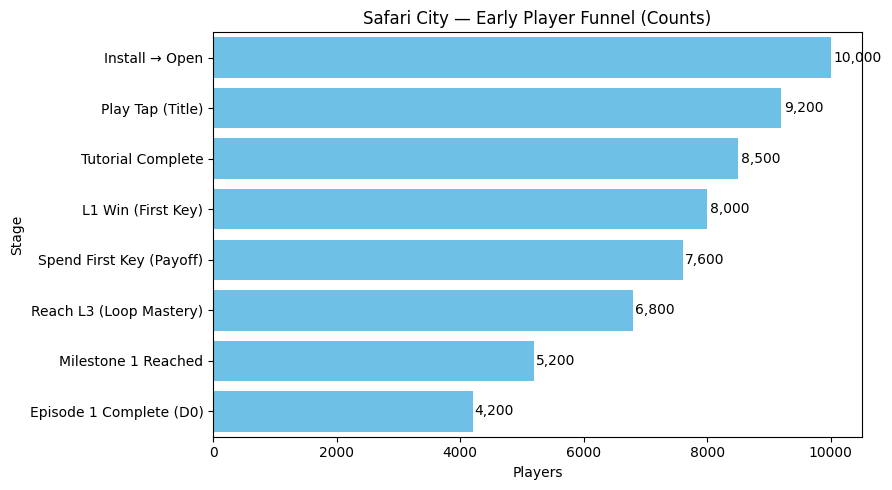

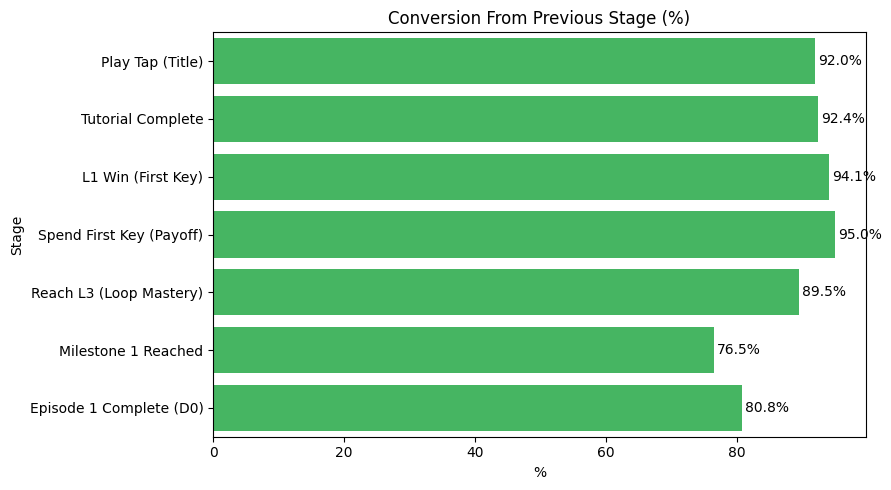

Saved charts to:
- c:\Safari City\funnel_counts.png
- c:\Safari City\funnel_conversion.png
Saved markdown to:
- c:\Safari City\Funnel_Insights_and_Recommendations.md


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4112\2796461166.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tut_conv = float(df_funnel.loc[df_funnel['stage']=='Tutorial Complete','conv_from_prev'])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4112\2796461166.py:52: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ep_conv = float(df_funnel.loc[df_funnel['stage']=='Episode 1 Complete (D0)','conv_from_start'])


In [ ]:
# Export visuals and a short insights report
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

OUT_DIR = Path(r"c:/Safari City")
OUT_COUNTS = OUT_DIR / "funnel_counts.png"
OUT_CONV = OUT_DIR / "funnel_conversion.png"
OUT_MD = OUT_DIR / "Funnel_Insights_and_Recommendations.md"

# Recreate and save Counts chart
plt.figure(figsize=(9,5))
sns.barplot(data=df_funnel, y='stage', x='count', color='#5ac8fa')
plt.title('Safari City — Early Player Funnel (Counts)')
plt.xlabel('Players')
plt.ylabel('Stage')
for i, c in enumerate(df_funnel['count']):
    plt.text(c*1.005, i, f"{c:,}", va='center')
plt.tight_layout()
plt.savefig(OUT_COUNTS, dpi=160)
plt.show()

# Recreate and save Conversion chart
plt.figure(figsize=(9,5))
sns.barplot(data=df_funnel.iloc[1:], y='stage', x=(df_funnel['conv_from_prev'].iloc[1:]*100), color='#34c759')
plt.title('Conversion From Previous Stage (%)')
plt.xlabel('%')
plt.ylabel('Stage')
for i, p in enumerate(df_funnel['conv_from_prev'].iloc[1:]*100):
    plt.text(p+0.5, i, f"{p:.1f}%", va='center')
plt.tight_layout()
plt.savefig(OUT_CONV, dpi=160)
plt.show()

# Build a short markdown summary
insights = df_funnel.iloc[1:].sort_values('drop_from_prev', ascending=False).head(3)
lines = []
lines.append("## Safari City — Early Funnel Insights\n")
lines.append("### Top Drop-offs\n")
for _, row in insights.iterrows():
    lines.append(f"- {row['stage']}: {row['drop_from_prev']*100:.1f}% drop from previous stage")

lines.append("\n### KPIs\n")
if 'Tutorial Complete' in df_funnel['stage'].values:
    tut_conv = float(df_funnel.loc[df_funnel['stage']=='Tutorial Complete','conv_from_prev'])
    lines.append(f"- Tutorial completion: {tut_conv*100:.1f}% (target ≥ 85%)")
if {'L1 Win (First Key)','Spend First Key (Payoff)'} <= set(df_funnel['stage']):
    key_gap = int(df_funnel.loc[df_funnel['stage']=='L1 Win (First Key)','count'].values[0] -
                  df_funnel.loc[df_funnel['stage']=='Spend First Key (Payoff)','count'].values[0])
    lines.append(f"- Earned key but not spent immediately: ~{key_gap:,} players")
if 'Episode 1 Complete (D0)' in df_funnel['stage'].values:
    ep_conv = float(df_funnel.loc[df_funnel['stage']=='Episode 1 Complete (D0)','conv_from_start'])
    lines.append(f"- D0 Episode 1 completion: {ep_conv*100:.1f}%")

lines.append("\n### Recommendations\n")
for _, row in insights.iterrows():
    stage = row['stage']
    if 'Tutorial' in stage:
        lines.append("- Tighten tutorial, show contextual gestures, defer non-critical prompts.")
    elif 'Spend First Key' in stage:
        lines.append("- After first win, auto-pan camera to task; pulse key slot; instant key feedback.")
    elif 'Reach L3' in stage:
        lines.append("- Smooth early difficulty; offer ad-continue on 2nd fail instead of gem paywall.")
    elif 'Milestone' in stage:
        lines.append("- Bundle small tasks into a bigger reveal; grant free booster at milestone.")
    elif 'Episode 1' in stage:
        lines.append("- Add cliffhanger and D1 notification with next-goal CTA.")

# Add explicit recommendation informed by external device testing
lines.append("- Ensure inclusivity for outdated devices: provide a lightweight build (reduced textures/effects), lower min-OS where safe, add device capability checks to auto-select the optimal build, and support intermittent connectivity.")

OUT_MD.write_text("\n".join(lines), encoding='utf-8')
print(f"Saved charts to:\n- {OUT_COUNTS}\n- {OUT_CONV}\nSaved markdown to:\n- {OUT_MD}")


In [ ]:
# Firebase funnel (CRISP-DM) — installs → level → purchase → uninstall
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path

# Load dataset
DATA_DIR = Path(r"c:/Safari City")
XLSX_PATH = DATA_DIR / "Firebase_overview.xlsx"

try:
	df_fb = pd.read_excel(XLSX_PATH)
except Exception as e:
	print(f"Could not read Excel: {e}")
	df_fb = pd.DataFrame()

# Extract event names and counts
events = {}
if not df_fb.empty:
	for i in range(len(df_fb)):
		event_name = str(df_fb.iloc[i, 0]).strip().lower()
		count = df_fb.iloc[i, 1]
		if isinstance(count, (int, float)):
			events[event_name] = events.get(event_name, 0) + float(count)
else:
	print("No Excel data loaded; using zeros.")

# Key funnel events
installs = int(events.get("first_open", 0))
levels = int(events.get("level_end", 0))
purchases = int(events.get("in_app_purchase", 0))
uninstalls = int(events.get("app_remove", 0))
sessions = float(events.get("session_start", 0))

# Metrics
conv_level = (levels / installs * 100) if installs else 0.0
conv_purchase = (purchases / installs * 100) if installs else 0.0
uninstall_rate = (uninstalls / installs * 100) if installs else 0.0
avg_sessions = (sessions / installs) if installs else 0.0

# Helpers
def fmt_short(n: float) -> str:
	abs_n = abs(n)
	if abs_n >= 1_000_000_000:
		return f"{n/1_000_000_000:.0f}B"
	if abs_n >= 1_000_000:
		return f"{n/1_000_000:.0f}M"
	if abs_n >= 1_000:
		return f"{n/1_000:.0f}K"
	return f"{n:.0f}"

# Plotly funnel
stages = ["Installs", "Level Completed", "In-App Purchase", "Uninstall"]
values = [installs, levels, purchases, uninstalls]
labels = [fmt_short(v) for v in values]

fig_crisp = go.Figure(go.Funnel(
	y=stages,
	x=values,
	textinfo="text+percent initial",
	text=labels,
	marker={"color": ["#00bfa5", "#64b5f6", "#ffb300", "#e57373"]},
))
fig_crisp.update_layout(
	title="Safari City — Firebase Funnel (CRISP-DM)",
	title_font=dict(size=20),
	margin=dict(l=120, r=20, t=60, b=40),
)
fig_crisp.show()

# Insights & recommendations
print("### Key Funnel Metrics")
print(f"- Installs: {installs:,}")
print(f"- Level Completions: {levels:,} ({conv_level:.1f}% of installs)")
print(f"- In-App Purchases: {purchases:,} ({conv_purchase:.3f}% of installs)")
print(f"- Uninstalls: {uninstalls:,} ({uninstall_rate:.1f}% of installs)")
print(f"- Avg Sessions per Player: {avg_sessions:.2f}")

print("\n### Insights")
if conv_level < 60:
	print("- Significant drop before completing first level → simplify onboarding/difficulty.")
if conv_purchase < 1:
	print("- Very low early monetization → add low-cost Starter IAP after Level 1.")
if uninstall_rate > 20:
	print("- High uninstall rate → reduce early friction, increase payoff feedback.")
if avg_sessions < 3:
	print("- Low engagement → daily login rewards and re-engagement notifications.")

print("\n### Recommendations")
print("""
1) Onboarding optimization: contextual guidance, shorter steps, softer early boards.
2) Starter IAP: $0.99 bundle (boosters/coins) after Level 1.
3) Retention loops: daily streaks and short quests to encourage D1/D2 returns.
4) Re-engagement: notifications 24–48h after inactivity.
5) Level balancing: A/B test L1–L3 for difficulty and pacing.
""")
